In [61]:
!pip install shap

In [62]:
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms

import shap

In [63]:
batch_size = 128
num_epochs = 2
device = torch.device("cpu")


class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}"
                f" ({100.0 * batch_idx / len(train_loader):.0f}%)]"
                f"\tLoss: {loss.item():.6f}"
            )


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        print(f"test loader shape: {len(test_loader)}")
        for data, target in test_loader:
           
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item()  # sum up batch loss
            pred = output.max(1, keepdim=True)[
                1
            ]  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(
        f"\nTest set: Average loss: {test_loss:.4f},"
        f" Accuracy: {correct}/{len(test_loader.dataset)}"
        f" ({100.0 * correct / len(test_loader.dataset):.0f}%)\n"
    )

# Reference: https://pytorch.org/docs/stable/data.html#iterable-style-datasets
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "mnist_data",
        train=True,
        download=True,
        transform=transforms.Compose([transforms.ToTensor()]),
    ),
    batch_size=batch_size,
    shuffle=True,
)

print(train_loader)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "mnist_data", train=False, transform=transforms.Compose([transforms.ToTensor()])
    ),
    batch_size=batch_size,
    shuffle=True,
)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306609
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.238223
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.578866
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.971226
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.765426
test loader shape: 79

Test set: Average loss: 0.0046, Accuracy: 9008/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.695915
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.573319
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.638106
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.462662
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.518821
test loader shape: 79

Test set: Average loss: 0.0026, Accuracy: 9368/10000 (94%)



In [64]:
def get_shap_values(explainer, test_data):
    return explainer.shap_values(test_data)

In [65]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_loader))
images, _ = batch

print(f"Shape of images: {len(batch)}")

background = images[:100]
test_images = images[100:103]

o = model(test_images)

e = shap.DeepExplainer(model, background)
print(e.shap_values)
shap_values = e.shap_values(test_images)

Shape of images: 2
<bound method DeepExplainer.shap_values of <shap.explainers._deep.DeepExplainer object at 0x3583a2c50>>


In [66]:
shap_numpy = list(np.transpose(shap_values, (4, 0, 2, 3, 1)))
print(f"Shap numpy: {len(shap_numpy)}")
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)
print(f"Test numpy: {test_numpy.shape}")

Shap numpy: 10
Test numpy: (3, 28, 28, 1)


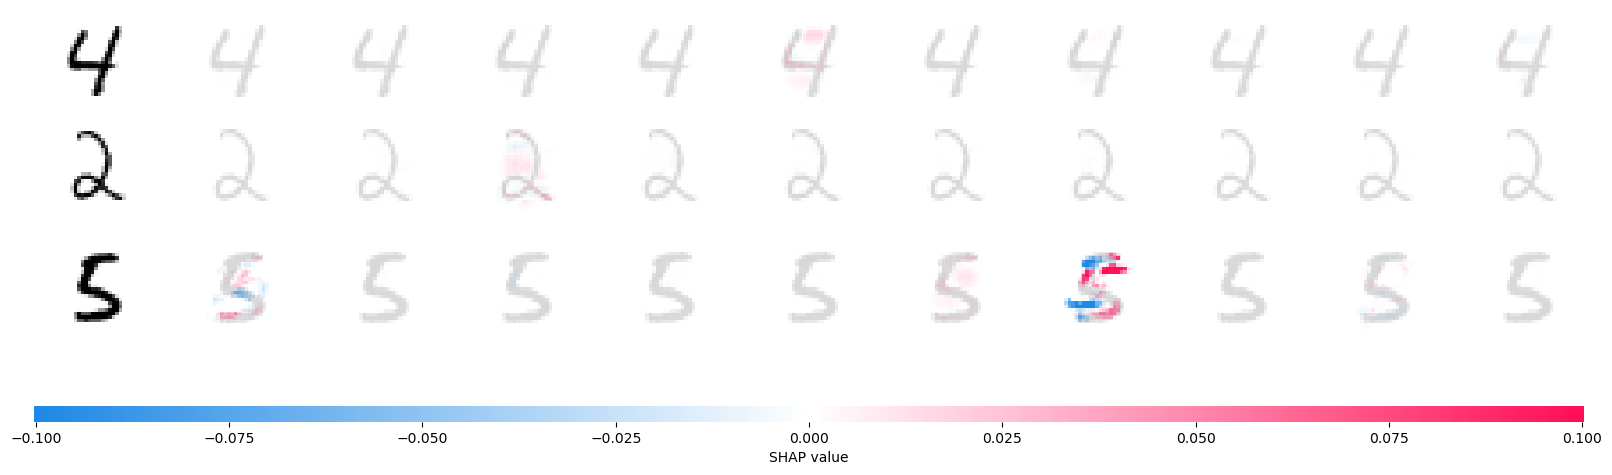

In [74]:
# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)

In [68]:
!pip install Flask

In [69]:
!pip install -U flask-cors
!pip install pillow 

In [70]:
import json
from json import JSONEncoder
import numpy as np
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [71]:
from flask import Flask
from flask import request, jsonify
from flask_cors import CORS

from PIL import Image
import json
import torchvision.transforms as transforms


# Define a transform to convert PIL 
# image to a Torch tensor
transform = transforms.Compose([
    transforms.PILToTensor()
])


app = Flask(__name__)
CORS(app)

# https://rapidapi.com/guides/upload-files-react-axios
@app.route('/upload', methods=['GET', 'POST'])
def upload_file():
    print(f"Req: {len(request.files)}")
    if request.method == 'POST':
        f = request.files['file']
        print(f"Found file: {f}")

        with Image.open(f) as image:

            img_tensor = transform(image)
            img_tensor = torch.div(img_tensor, 255)
            # Reference: https://pytorch.org/docs/stable/generated/torch.Tensor.expand.html
            # Reference: https://medium.com/@goelpulkit43/deploy-a-pytorch-convolutional-neural-network-via-rest-api-using-flask-40bf0facd65d
            img_tensor = img_tensor.expand(1, 1, 28, 28)
            # print the converted Torch tensor
            # print(img_tensor)

            val = get_shap_values(e, img_tensor)

            print(val)
            # Reference: https://pynative.com/python-serialize-numpy-ndarray-into-json/
            numpyData = {"array": val}
            encodedNumpyData = json.dumps(numpyData, cls=NumpyArrayEncoder)

            # Reference: https://pillow.readthedocs.io/en/stable/handbook/concepts.html
            # print(f"Image mode: {im.mode}")

            

    return encodedNumpyData

In [75]:

app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
